In [14]:
import numpy as np
import pandas as pd

# import the full dataset
train_df = pd.read_csv("MSD_Random_final.csv")

train_df.head()
#print(train_df.dtypes)

,track,artist,year,songHotness,artistFamiliarity,artistHotness,tempo,loudness,timeSignature,timeSignatureConfidence,...,meanSegmentTimbre_4,meanSegmentTimbre_5,meanSegmentTimbre_6,meanSegmentTimbre_7,meanSegmentTimbre_8,meanSegmentTimbre_9,meanSegmentTimbre_10,meanSegmentTimbre_11,meanSegmentTimbre_12,mood
0,1492,Scarlet's Remains,2005,0.480329,0.527865,0.393122,170.702,-8.039,4,0.000,...,-18.470993,-26.766461,-25.799706,-9.299924,0.715250,16.093052,10.243695,-1.627153,-0.370248,angry
1,3,Britney Spears,2009,NaN,0.947328,0.607257,131.999,-6.278,5,1.000,...,24.121261,-10.098948,-27.991685,12.579932,13.030615,1.277526,7.914643,8.166655,4.393197,excited
2,6TH Avenue Nightmare,Pennywise,2005,NaN,0.816998,0.512229,200.877,-5.111,4,0.000,...,-4.658868,-16.925334,-24.970354,-0.425289,-2.649020,4.413962,8.586962,-1.523461,-7.412026,excited
3,A Fall Song,Cross Country,2009,0.212045,0.375196,0.355708,129.169,-11.724,4,0.740,...,-24.129409,-21.244851,-8.162045,-14.814279,-6.644438,15.258909,2.010770,-0.351881,18.288453,calm
4,A Talk With Dad,Speech,2003,0.000000,0.596276,0.341960,73.110,-22.033,5,0.814,...,24.388637,-50.084265,27.441135,-46.799413,12.328803,-32.840594,0.236399,0.297869,25.662531,calm


In [24]:
# select indices of the features to be extracted
feature_indices = np.append(np.array([2,6,7,8,10,12]), np.arange(14,26))

# extract the relevant features values from the dataset
X_train = train_df.iloc[:,feature_indices]

# extract the mood labels
y_train = train_df['mood']
y_train.value_counts()

excited    86
happy      75
angry      73
calm       72
sad        39
Name: mood, dtype: int64

In [25]:
#X_train.head()
print(X_train.shape)
print(X_train.dtypes)
print(y_train.shape)
print(y_train.dtypes)
feature_names = list(X_train)


(345, 18)
year                      int64
tempo                   float64
loudness                float64
timeSignature             int64
key                       int64
mode                      int64
meanSegmentTimbre_1     float64
meanSegmentTimbre_2     float64
meanSegmentTimbre_3     float64
meanSegmentTimbre_4     float64
meanSegmentTimbre_5     float64
meanSegmentTimbre_6     float64
meanSegmentTimbre_7     float64
meanSegmentTimbre_8     float64
meanSegmentTimbre_9     float64
meanSegmentTimbre_10    float64
meanSegmentTimbre_11    float64
meanSegmentTimbre_12    float64
dtype: object
(345,)
object


In [17]:
# import required modules from scikit-learn
from sklearn import svm
from sklearn.compose import make_column_transformer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

In [18]:
# define a column transformer for one-hot encoding of the "key" feature
column_trans = make_column_transformer((preprocessing.OneHotEncoder(), ['key']),
                                      remainder = 'passthrough')

In [19]:
# define a grid of parameters to be explored by "GridSearchCV"
# just using C=1 here
tuned_parameters = [
    {'linearsvc__C': [1]#[0.001, 0.01, 0.1, 1]#, 10, 100],
     #'linearsvc__loss': ['hinge', 'squared_hinge'], 
     #'linearsvc__dual': [False, True],
     #'linearsvc__penalty': ['l1', 'l2'],
    }
 ]

# what kind of scoring is to be used by GridSearchCV for evaluation
scores = ['balanced_accuracy']

# create a pipeline for the learning - column transformer is commented out
# the data is centered at zero and scaled for a variance of 1 before running SVC
mypipeline = make_pipeline(#column_trans, 
                           preprocessing.StandardScaler(),
                           svm.LinearSVC(class_weight='balanced',max_iter=10000,tol=1e-4))

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    # define the grid search object
    clf = GridSearchCV(mypipeline,
                       tuned_parameters, scoring=score, cv=5, n_jobs=-1
                      )
    # run the grid search on the dataset
    clf.fit(X_train, y_train)

    # Print out the best set of parameters and the scoring for all attempted sets
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


# Tuning hyper-parameters for balanced_accuracy

Best parameters set found on development set:

{'linearsvc__C': 1}

Grid scores on development set:

0.439 (+/-0.092) for {'linearsvc__C': 1}



In [20]:
# define a new pipeline with the best parameters and fit it to the dataset
best = mypipeline.set_params(**clf.best_params_)
best.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=10000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [21]:
# extract the mood labels and feature weights from the learned model for plotting
print(best.classes_)
moods = best['linearsvc'].classes_
print(moods)
feature_weights = best['linearsvc'].coef_
print(feature_weights.shape)

['angry' 'calm' 'excited' 'happy' 'sad']
['angry' 'calm' 'excited' 'happy' 'sad']
(5, 18)


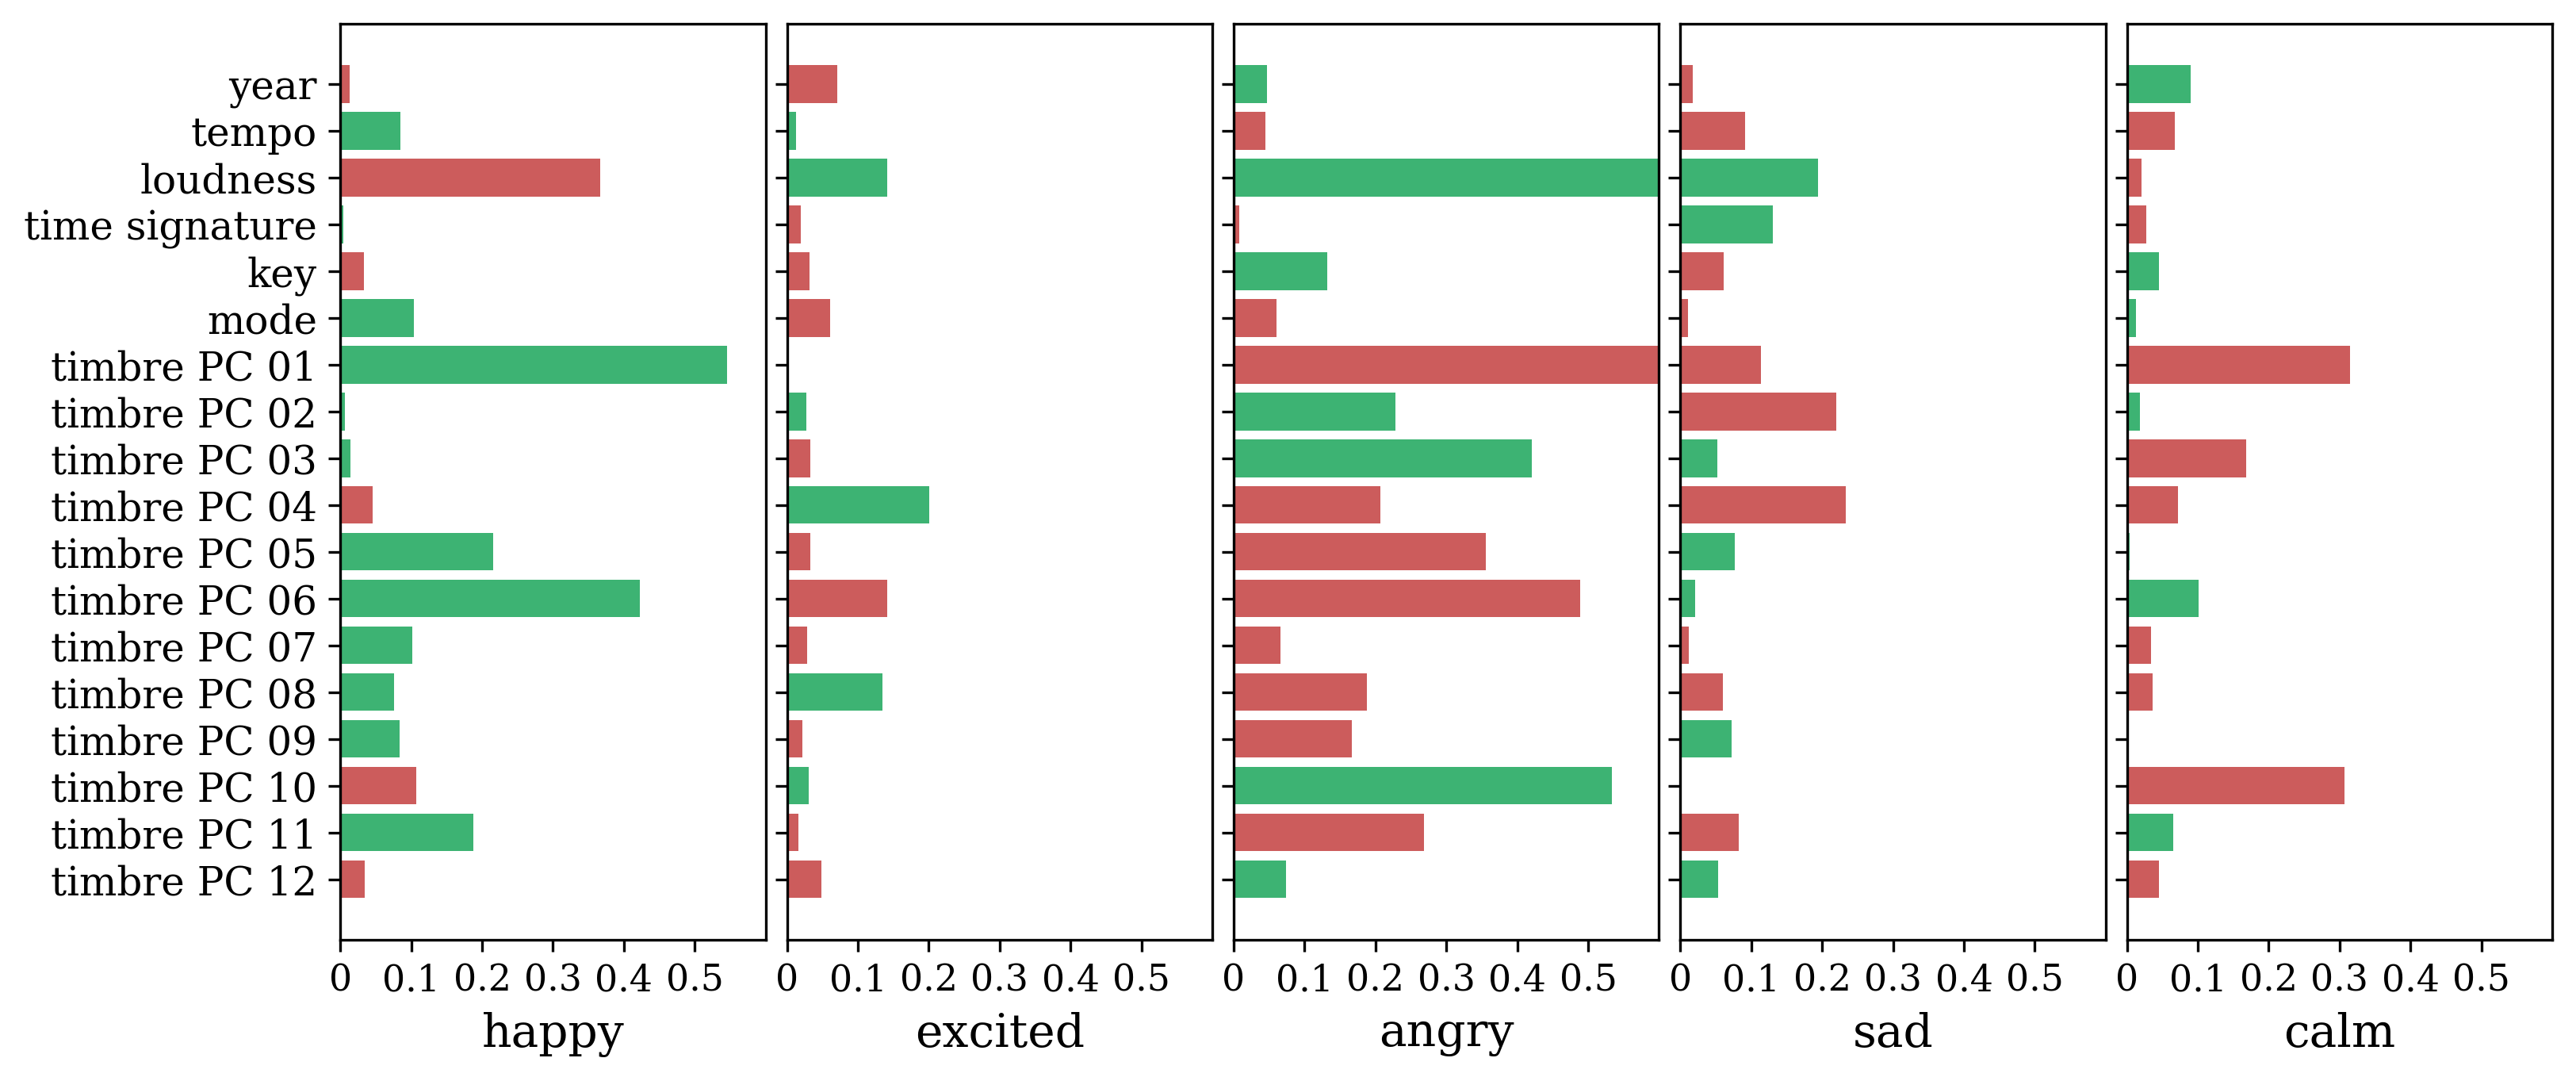

In [22]:
# plot the absolute feature weights for each mood class

import matplotlib.pyplot as plt

colorindex = (feature_weights > 0).astype('int')
mycolors = np.array([(0.8,0.36,0.36), (0.24,0.7,0.45)])

mood_order = [3, 2, 0, 4, 1]

fig, ax = plt.subplots(1,5,sharey=True,figsize=(12,5),dpi=300)

sp=0
for m in mood_order:
    
    plt.rcdefaults()
    ax[sp].barh(feature_names, np.abs(feature_weights[m]), color=mycolors[np.array(colorindex[m])])
            
    ax[sp].invert_yaxis()  # labels read top-to-bottom
    ax[sp].set_xlim(0,0.6)
    ax[sp].set_xlabel('%s' % moods[m], fontname="serif", fontsize=14)
    ax[sp].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
    ax[sp].set_xticklabels([0,0.1,0.2,0.3,0.4,0.5], fontname="serif", fontsize=11)
    ax[sp].set_yticklabels(['year','tempo','loudness','time signature','key','mode',
                           'timbre PC 01','timbre PC 02','timbre PC 03','timbre PC 04',
                           'timbre PC 05','timbre PC 06','timbre PC 07','timbre PC 08',
                           'timbre PC 09','timbre PC 10','timbre PC 11','timbre PC 12',], 
                           fontname="serif", fontsize=12)
    
    sp +=1

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('fweights_all_horizontal.eps', bbox_inches='tight')
plt.show()

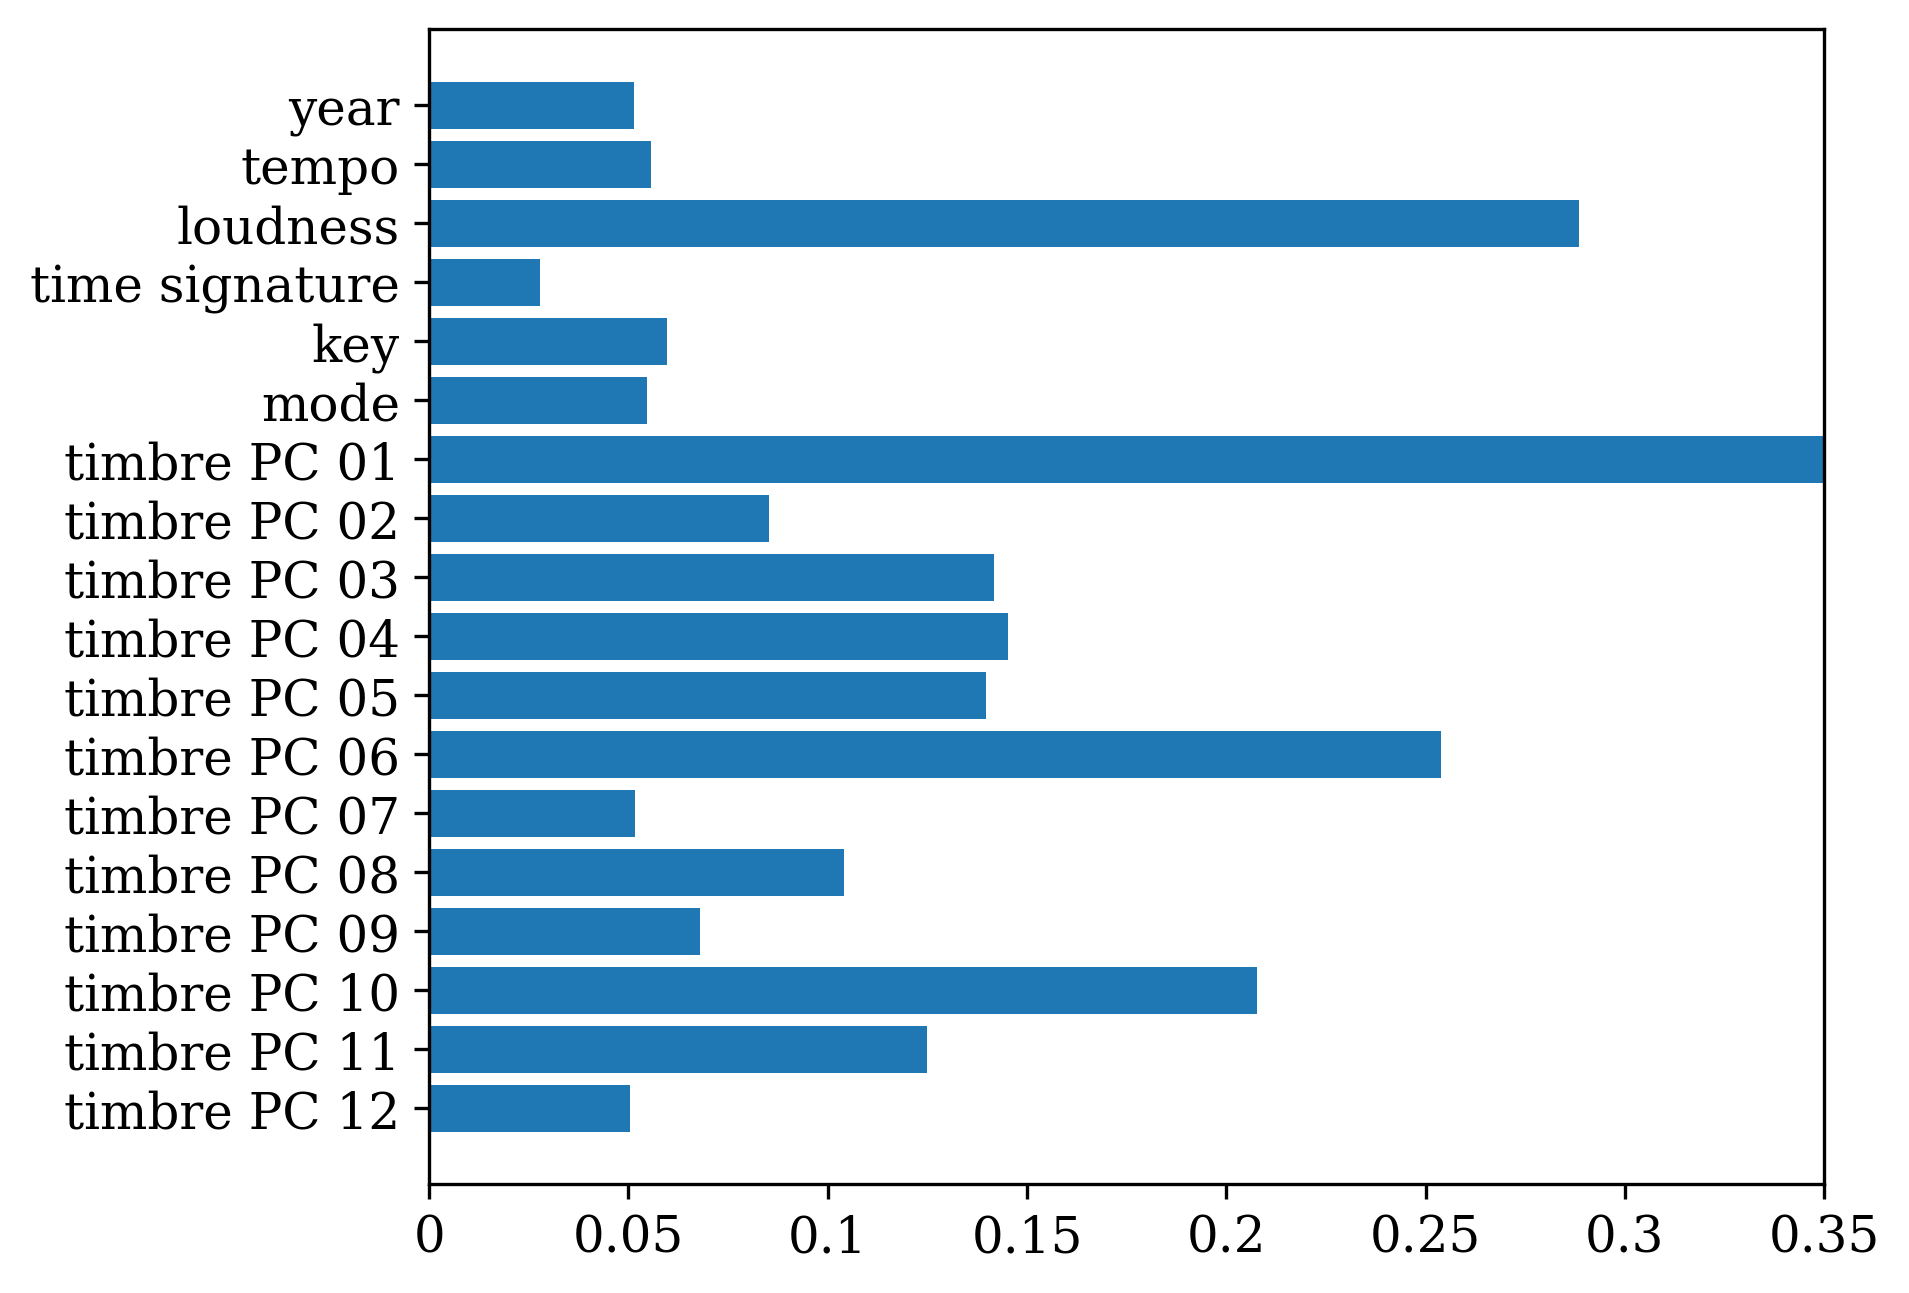

In [23]:
# plot the weighted average of the absolute feature weights

weights = [73, 72, 86, 75, 39]
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6,5),dpi=300)
ax.barh(feature_names, np.average(np.abs(feature_weights),axis=0,weights=weights))

ax.set_xticklabels([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35], fontname="serif", fontsize=12)
ax.set_yticklabels(['year','tempo','loudness','time signature','key','mode',
                           'timbre PC 01','timbre PC 02','timbre PC 03','timbre PC 04',
                           'timbre PC 05','timbre PC 06','timbre PC 07','timbre PC 08',
                           'timbre PC 09','timbre PC 10','timbre PC 11','timbre PC 12',], 
                           fontname="serif", fontsize=12)
    
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlim(0,0.35)
#plt.title('Mean of absolute feature weights across all mood classes')
plt.savefig('fweights_mean.eps', bbox_inches='tight')
plt.show()